Le jeu de données utilisé est un dataset de feuilles d’arbres. L’objectif est de les catégoriser par espèce d’arbre à partir de leur caractéristiques. 
Les caractéristiques extraites des images des feuilles sont essentiellement 3 vecteurs de dimension 64 (margin, shape & texture), dont la description du dataset détaillée se trouve ici : https://www.kaggle.com/c/leaf-classification/data

In [1]:
# coding: utf-8
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings(action='ignore')

seed = 42

# Chargement et préparation des données

In [2]:
feuilles_train = pd.read_csv('dataset_feuilles.csv')
feuilles_train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [3]:
feuilles_train.species.unique().shape

(99,)

Il ya 99 espèces différentes.

In [4]:
feuilles_train.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


Il ne semble pas y avoir de données aberrantes.

Découpons les données en un jeu d'entrainement et un jeu de test :

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(feuilles_train.iloc[:,2:195], 
                                                feuilles_train['species'], 
                                                train_size=0.8, 
                                                random_state = seed)

# Création d'une baseline de performances avec KNN

On peut créer un premier classifieur 3-NN, c'est à dire qui prend en compte les 3 plus proches voisins pour la classification. Pour cela on va utiliser l'implémentation de l'algorithme qui existe dans la librairie sklearn :

In [6]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

L'algorithme ici n'effectue aucune optimisation, mais va juste sauvegarder toutes les données en mémoire.
Testons à présent l’erreur de notre classifieur :

In [7]:
error = 1 - knn.score(xtest, ytest)
print('Erreur: %0.3f %%' % (error*100))

Erreur: 13.131 %


Pour trouver le k optimal, on va simplement tester le modèle pour tous les k de 2 à 15, mesurer l’erreur test et afficher la performance en fonction de k :

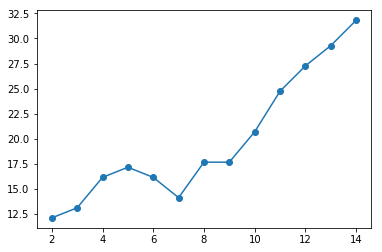

In [8]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [9]:
K = np.argmin(errors) + 2
print("Le K optimal est K = ", K)

Le K optimal est K =  2


In [10]:
print('Erreur : %0.3f %%' % min(errors))

Erreur : 12.121 %


In [11]:
ypred = knn.predict(xtest)
cm_knn = confusion_matrix(ytest, ypred)

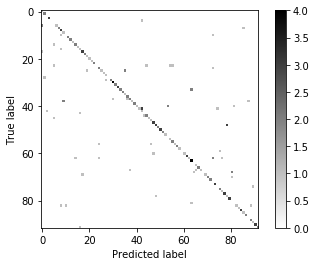

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(cm_knn, interpolation='nearest', cmap=plt.cm.binary)
ax.figure.colorbar(im, ax=ax)
ax.set(ylabel='True label',
       xlabel='Predicted label')

plt.show()

# SVM avec OVR (One Versus Rest)

Créons une variable pour fixer les folds dans les validations croisées :

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

Nous allons d'abord appliquer le principe OVR (One Versus Rest) à une classification linéaire SVM, en testant différents paramètres de régularisations (C) :

In [14]:
svm_ovr = LinearSVC(multi_class='ovr')

params = { 'C': np.logspace(-3, 3, 7) }

gs_svm_ovr = GridSearchCV(svm_ovr, params, cv=kf)
gs_svm_ovr.fit(xtrain, ytrain)

print(gs_svm_ovr.best_params_)

error = 1 - gs_svm_ovr.score(xtest, ytest)
print('Erreur: %0.3f %%' % (error*100))

{'C': 100.0}
Erreur: 3.030 %


L'erreur est bien plus faible qu'avec le modèle KNN !
C'est d'ailleurs visible sur la matrice de confusion :

In [15]:
ypred = gs_svm_ovr.predict(xtest)
cm_svm_ovr = confusion_matrix(ytest, ypred)

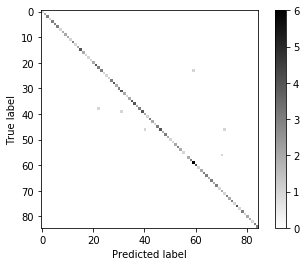

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(cm_svm_ovr, interpolation='nearest', cmap=plt.cm.binary)
ax.figure.colorbar(im, ax=ax)
ax.set(ylabel='True label',
       xlabel='Predicted label')

plt.show()

# SVM multi-classes avec Crammer Singer

Maintenant nous appliquons le principe de Crammer-Singer à une classification linéaire SVM, en testant différents paramètres de régularisations (C) :

In [17]:
svm_cs = LinearSVC(multi_class='crammer_singer')

params = { 'C': np.logspace(-3, 3, 7) }

gs_svm_cs = GridSearchCV(svm_cs, params, cv=kf)
gs_svm_cs.fit(xtrain, ytrain)

print(gs_svm_cs.best_params_)

error = 1 - gs_svm_cs.score(xtest, ytest)
print('Erreur: %0.3f %%' % (error*100))

{'C': 1000.0}
Erreur: 4.040 %


In [18]:
ypred = gs_svm_cs.predict(xtest)
cm_svm_cs = confusion_matrix(ytest, ypred)

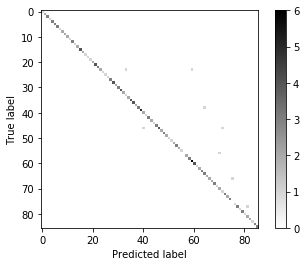

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(cm_svm_cs, interpolation='nearest', cmap=plt.cm.binary)
ax.figure.colorbar(im, ax=ax)
ax.set(ylabel='True label',
       xlabel='Predicted label')

plt.show()

Les modèles SVM avec OVR ou Crammer-Singer sont à peu près équivalents (OVR étant un peu meilleur) et sont beaucoup plus performants que le modèle KNN.

# Catégorisation du jeu de test

On commence par charger les données du jeu de test :

In [20]:
feuilles_test = pd.read_csv('test_feuilles.csv')
print(len(feuilles_test), "observations")
feuilles_test.head()

594 observations


,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


On réalise les prédictions avec les 2 méthodes SVM et on ajoute les résultats au dataframe :

In [21]:
feuilles_test_pred_ovr = gs_svm_ovr.predict(feuilles_test.iloc[:,1:])
feuilles_test_pred_cs = gs_svm_cs.predict(feuilles_test.iloc[:,1:])

feuilles_test['pred_OVR'] = feuilles_test_pred_ovr
feuilles_test['pred_CS'] = feuilles_test_pred_cs

Ecart de prédiction entre les méthodes SVM OCR et SVM CS :

In [22]:
feuilles_test[feuilles_test['pred_OVR'] != feuilles_test['pred_CS']]

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64,pred_OVR,pred_CS
268,690,0.025391,0.058594,0.060547,0.003906,0.003906,0.105470,0.027344,0.000000,0.000000,...,0.001953,0.008789,0.012695,0.000977,0.0,0.035156,0.000000,0.059570,Quercus_Semecarpifolia,Liriodendron_Tulipifera
313,829,0.039062,0.158200,0.021484,0.001953,0.000000,0.205080,0.015625,0.000000,0.001953,...,0.037109,0.000000,0.003906,0.000000,0.0,0.000000,0.000000,0.057617,Lithocarpus_Edulis,Lithocarpus_Cleistocarpus
361,982,0.072266,0.138670,0.001953,0.001953,0.000000,0.158200,0.007812,0.000000,0.001953,...,0.041992,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Lithocarpus_Cleistocarpus,Magnolia_Heptapeta
439,1162,0.058594,0.128910,0.013672,0.005859,0.000000,0.134770,0.007812,0.000000,0.007812,...,0.010742,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,Quercus_Phellos,Magnolia_Heptapeta
448,1190,0.005859,0.000000,0.015625,0.011719,0.019531,0.003906,0.017578,0.005859,0.005859,...,0.000000,0.006836,0.023438,0.000000,0.0,0.000000,0.000000,0.022461,Tilia_Oliveri,Castanea_Sativa
490,1304,0.025391,0.099609,0.007812,0.019531,0.000000,0.107420,0.005859,0.000000,0.005859,...,0.000000,0.007812,0.023438,0.003906,0.0,0.013672,0.031250,0.006836,Cytisus_Battandieri,Eucalyptus_Glaucescens
493,1313,0.033203,0.015625,0.023438,0.035156,0.001953,0.048828,0.013672,0.000000,0.000000,...,0.000000,0.018555,0.000977,0.025391,0.0,0.137700,0.000000,0.000000,Quercus_Rhysophylla,Quercus_Ilex
496,1316,0.009766,0.000000,0.029297,0.035156,0.015625,0.009766,0.017578,0.000000,0.005859,...,0.000000,0.062500,0.034180,0.000977,0.0,0.021484,0.000000,0.000000,Quercus_Pubescens,Tilia_Oliveri
517,1382,0.021484,0.017578,0.042969,0.019531,0.003906,0.019531,0.037109,0.000000,0.007812,...,0.004883,0.000977,0.012695,0.004883,0.0,0.032227,0.005859,0.041016,Quercus_Imbricaria,Quercus_Trojana


In [23]:
print(
    "On a", 
    round(100*len(feuilles_test[feuilles_test['pred_OVR'] != feuilles_test['pred_CS']])/len(feuilles_test), 2), 
    "% de différences de prédictions entre les 2 méthodes.")

On a 1.52 % de différences de prédictions entre les 2 méthodes.


On va conserver le modèle OVR puisque c'est celui qui était le plus performant sur le jeu d'entrainement. 